In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [36]:
from src.load_data import load_data

epoch_key = 'Jaq', 3, 12 # animal, day, epoch

data = load_data(epoch_key)

30-Nov-20 16:42:17 Loading position info...
30-Nov-20 16:47:09 Failed to load file: /Users/edeno/Documents/GitHub/pose_analysis/src/../Raw-Data/Jaq/JaqDIO03.mat
30-Nov-20 16:47:09 No DIO file found, using distance from well to segment trials
30-Nov-20 16:47:09 Failed to load file: /Users/edeno/Documents/GitHub/pose_analysis/src/../Raw-Data/Jaq/JaqDIO03.mat
30-Nov-20 16:47:09 No DIO file found, inferring correct inbound/outbound from task rules
30-Nov-20 16:47:11 Loading multiunit...
30-Nov-20 16:47:49 Loading spikes...
30-Nov-20 16:48:53 Finding ripple times...


In [ ]:
EDGE_ORDER = [(0, 1), (1, 2), (2, 3), (1, 4), (4, 5)]
EDGE_SPACING = [15, 0, 15, 0]

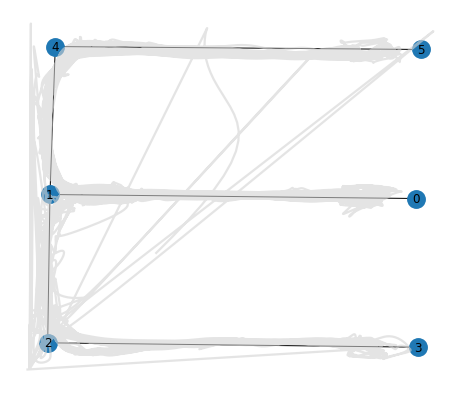

In [91]:
from track_linearization import plot_track_graph

plt.figure(figsize=(8, 7))
plt.plot(data['position_info'].tailBase_x, data['position_info'].tailBase_y, color='lightgrey', alpha=0.6)
plot_track_graph(data['track_graph'])
sns.despine(bottom=True, left=True)

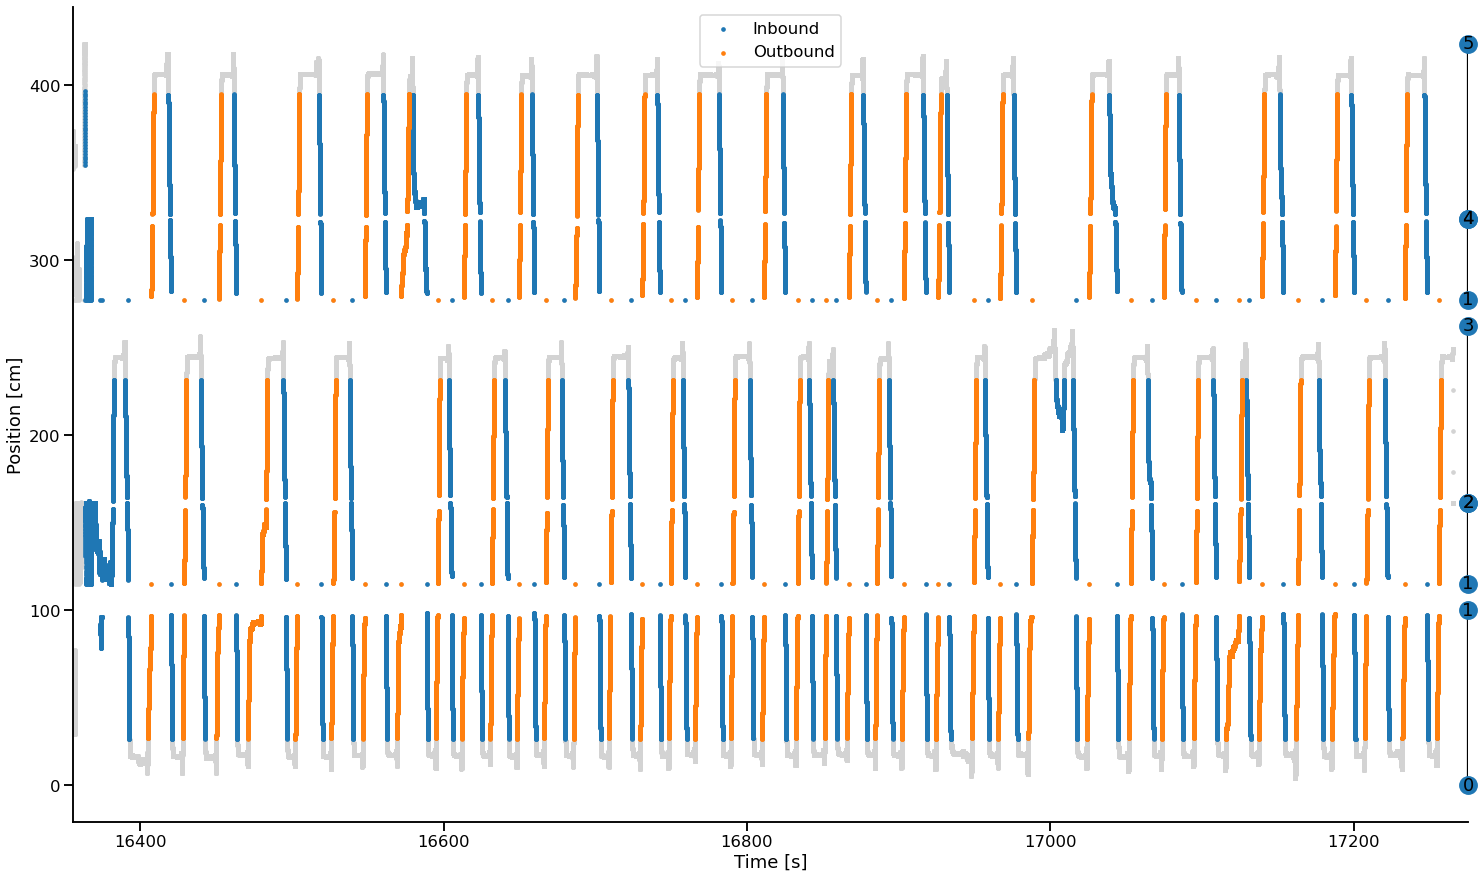

In [86]:
from track_linearization import plot_graph_as_1D

plt.figure(figsize=(25, 15))

time = data['position_info'].index / np.timedelta64(1, 's')
plt.scatter(time,
            data['position_info'].linear_position, color='lightgrey', s=10)

for name, df in data['position_info'].groupby('task'):
    plt.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=10, label=name)

plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=10.0 + time[-1])

plt.legend()
plt.ylabel('Position [cm]')
plt.xlabel('Time [s]')
plt.xlim((time[0], time[-1] + 10.0))

sns.despine()

In [92]:
continuous_transition_types = (
    [['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform'],
     ['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform']])

encoding_group_to_state = ['Inbound', 'Inbound', 'Outbound', 'Outbound']


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

In [69]:
from replay_trajectory_classification import ClusterlessClassifier

classifier = ClusterlessClassifier(**classifier_parameters)

In [94]:
data["position_info"].task.unique()

array([nan, 'Inbound', 'Outbound'], dtype=object)

In [75]:
import pandas as pd

inbound_outbound_labels = np.asarray(data["position_info"].task).astype(str)

is_running = (np.abs(data["position_info"].tailBase_vel) > 4) & pd.notnull(data["position_info"].task)

classifier.fit(
    position=data["position_info"].linear_position,
    multiunits=data["multiunits"],
    is_training=is_running,
    track_graph=data["track_graph"],
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
    encoding_group_labels=inbound_outbound_labels,
    encoding_group_to_state=encoding_group_to_state
)

01-Dec-20 11:48:34 Fitting initial conditions...
01-Dec-20 11:48:34 Fitting state transition...
01-Dec-20 11:48:37 Fitting multiunits...


ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'random_walk', 'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform', 'uniform'],
                                                   ['random_walk', 'uniform',
                                                    'random_walk', 'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform', 'uniform']],
                      discrete_transition_diag=0.968,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([20., 20., 

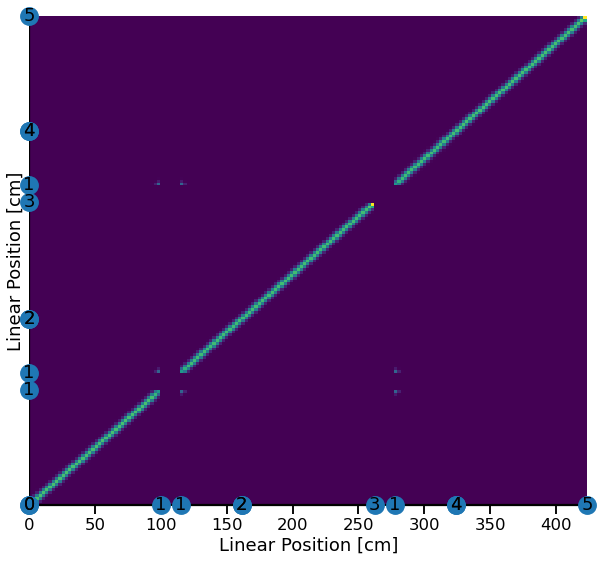

In [117]:

plt.figure(figsize=(10, 9))
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[0, 0].T)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)

In [211]:
data['ripple_times']

,start_time,end_time,duration
replay_number,,,
1,0 days 04:33:04.373699999,0 days 04:33:04.455033333,0.081333
2,0 days 04:33:05.002366666,0 days 04:33:05.095699999,0.093333
3,0 days 04:33:06.387033333,0 days 04:33:06.594366666,0.207333
4,0 days 04:33:14.317033333,0 days 04:33:14.370366666,0.053333
5,0 days 04:33:16.437033333,0 days 04:33:16.547699999,0.110667
...,...,...,...
205,0 days 04:47:31.024366666,0 days 04:47:31.125033333,0.100667
206,0 days 04:47:32.435699999,0 days 04:47:32.514366666,0.078667
207,0 days 04:47:33.106366666,0 days 04:47:33.172366666,0.066000


In [191]:
def plot_ripple_decode(data, classifier, ripple_number):
    start_time = data['ripple_times'].loc[ripple_number].start_time
    end_time = data['ripple_times'].loc[ripple_number].end_time

    results = classifier.predict(
        multiunits=data['multiunits'].sel(time=slice(start_time, end_time)),
        time=data['multiunits'].sel(time=slice(start_time, end_time)).time / np.timedelta64(1, 's'),
        state_names=['Inbound-Continuous', 'Inbound-Fragmented', 'Outbound-Continuous', 'Outbound-Fragmented']
        )

    fragmented = (results
                  .acausal_posterior
                  .sel(state=['Inbound-Fragmented', 'Outbound-Fragmented'])
                  .sum(['state', 'position'])
                  .assign_coords({'state': 'Fragmented'}))
    probability = (results
                   .acausal_posterior
                   .sum('position')
                   .drop_sel(state=['Inbound-Fragmented', 'Outbound-Fragmented']))
    probability = xr.concat((probability, fragmented), dim='state')

    fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(15, 8))
    probability.plot(x='time', hue='state', ax=axes[0])
    results.acausal_posterior.sum('state', skipna=False).plot(x='time', y='position', ax=axes[1], robust=True, vmin=0.0)
    sns.despine()

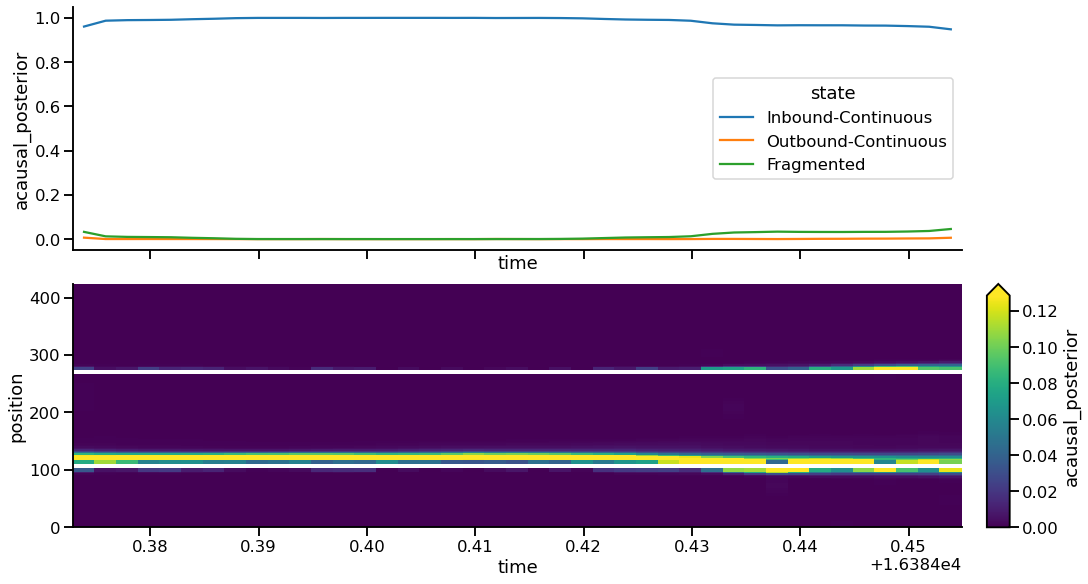

In [192]:
ripple_number = 1

plot_ripple_decode(data, classifier, ripple_number)

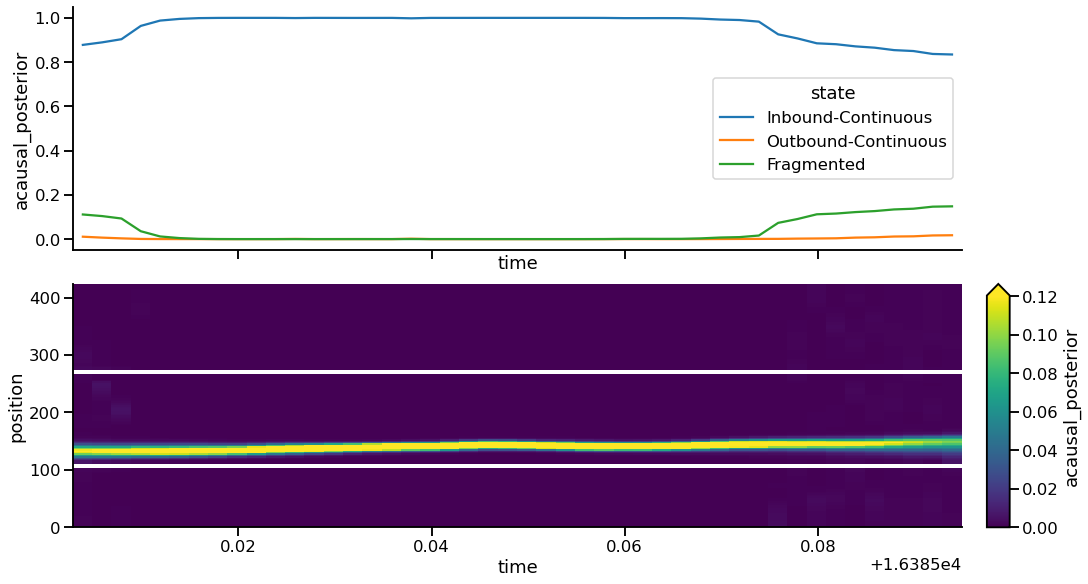

In [193]:
ripple_number = 2

plot_ripple_decode(data, classifier, ripple_number)

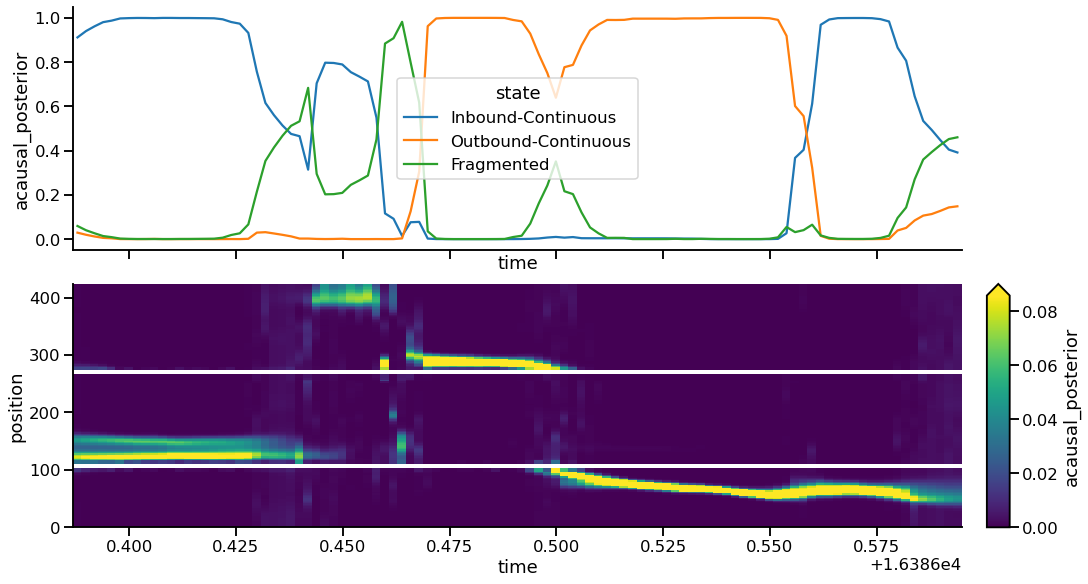

In [194]:
ripple_number = 3

plot_ripple_decode(data, classifier, ripple_number)

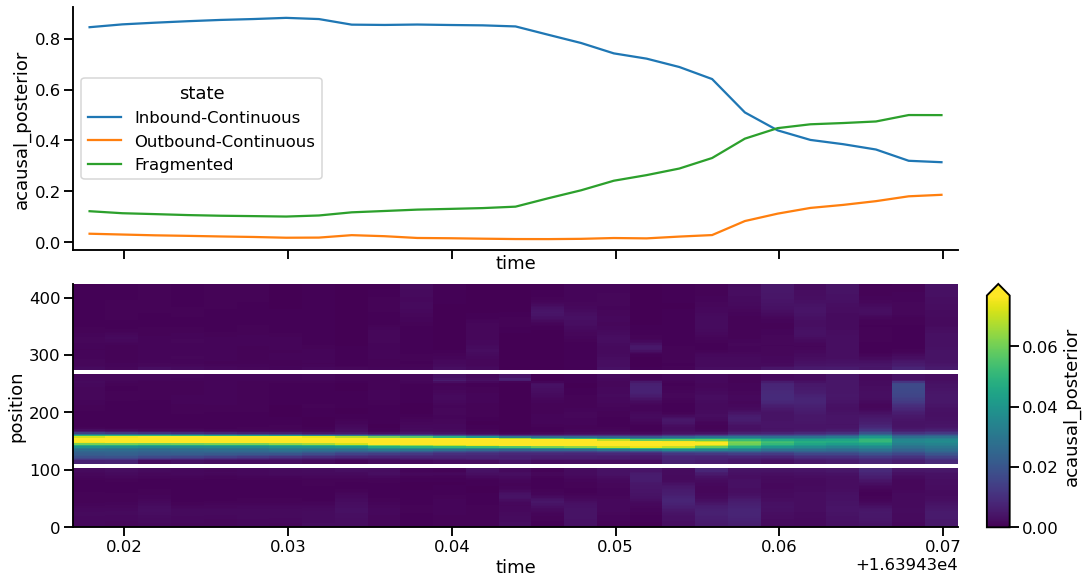

In [195]:
ripple_number = 4

plot_ripple_decode(data, classifier, ripple_number)

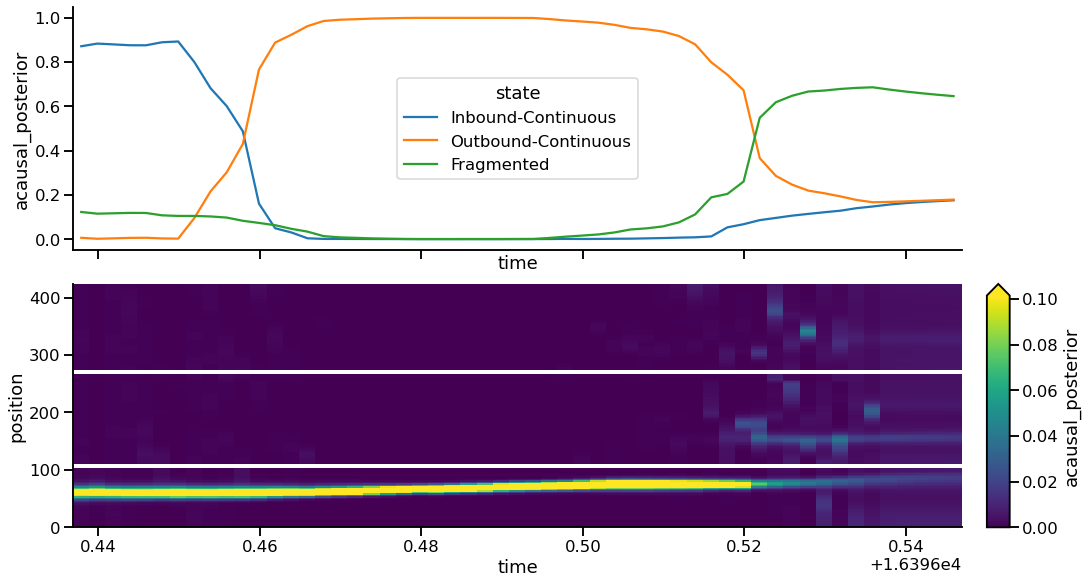

In [196]:
ripple_number = 5

plot_ripple_decode(data, classifier, ripple_number)

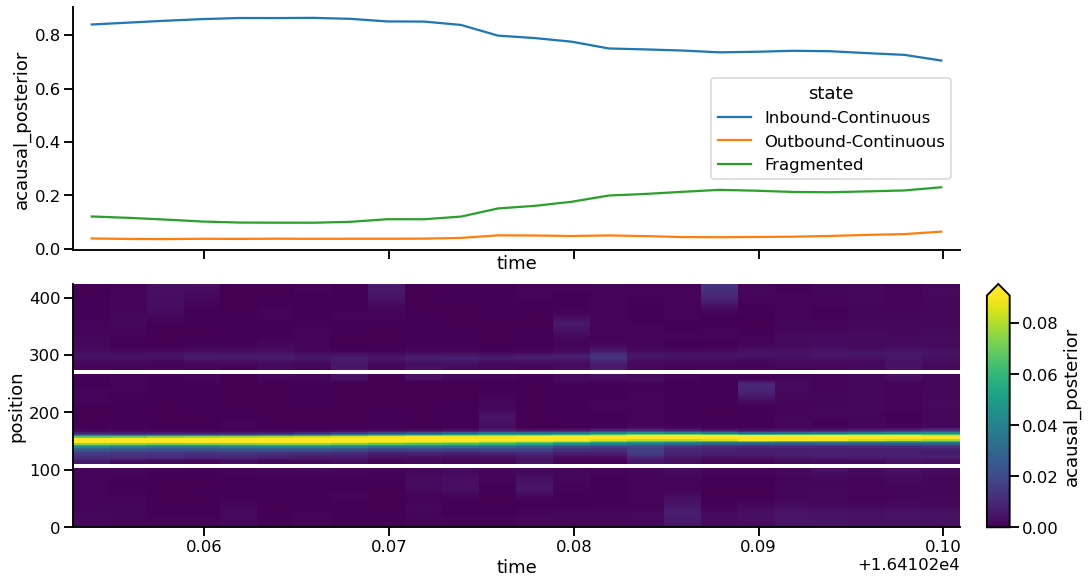

In [197]:
ripple_number = 6

plot_ripple_decode(data, classifier, ripple_number)

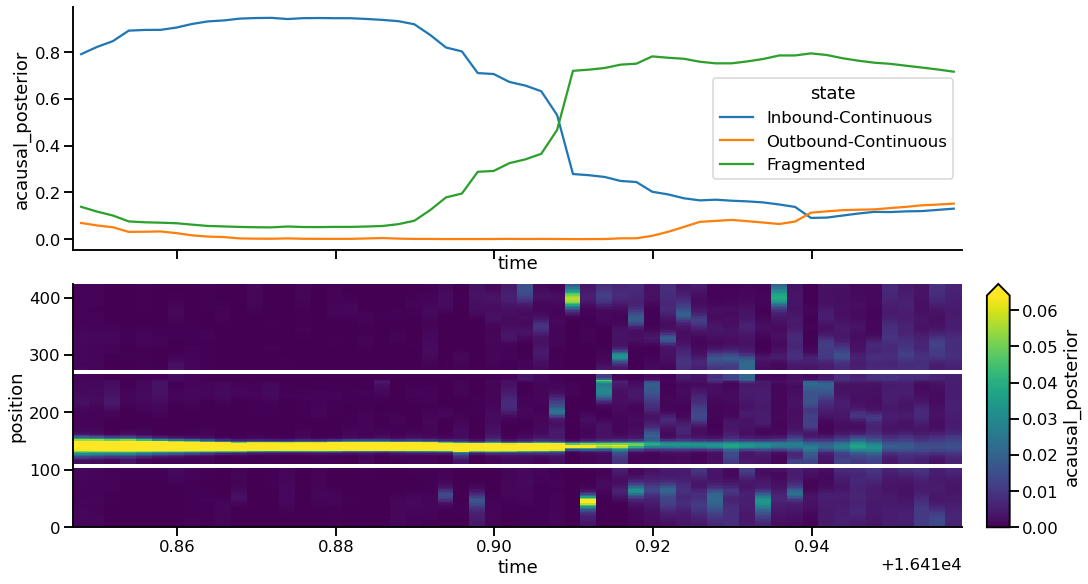

In [198]:
ripple_number = 7

plot_ripple_decode(data, classifier, ripple_number)

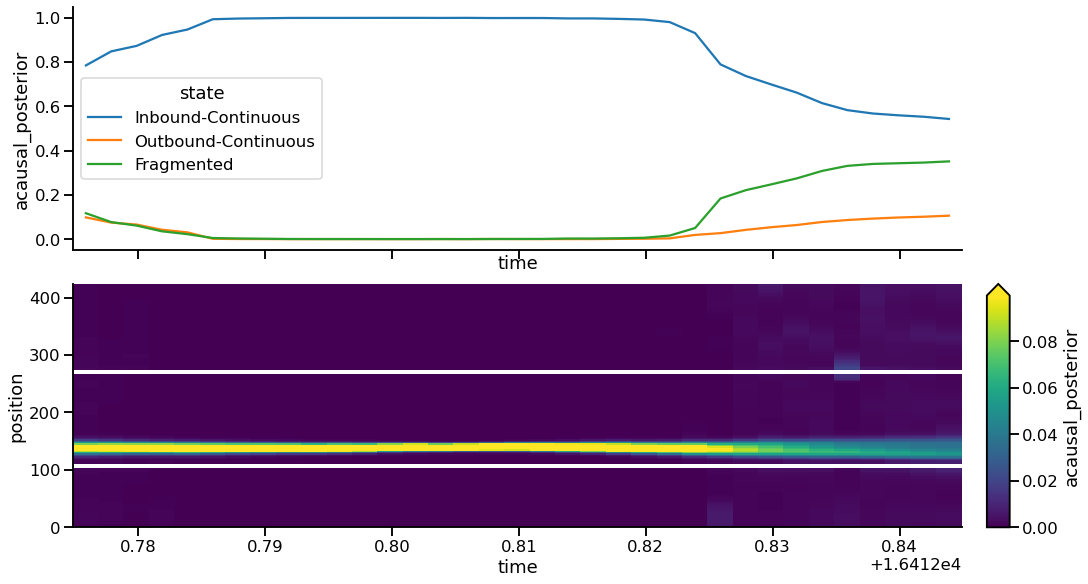

In [199]:
ripple_number = 8

plot_ripple_decode(data, classifier, ripple_number)

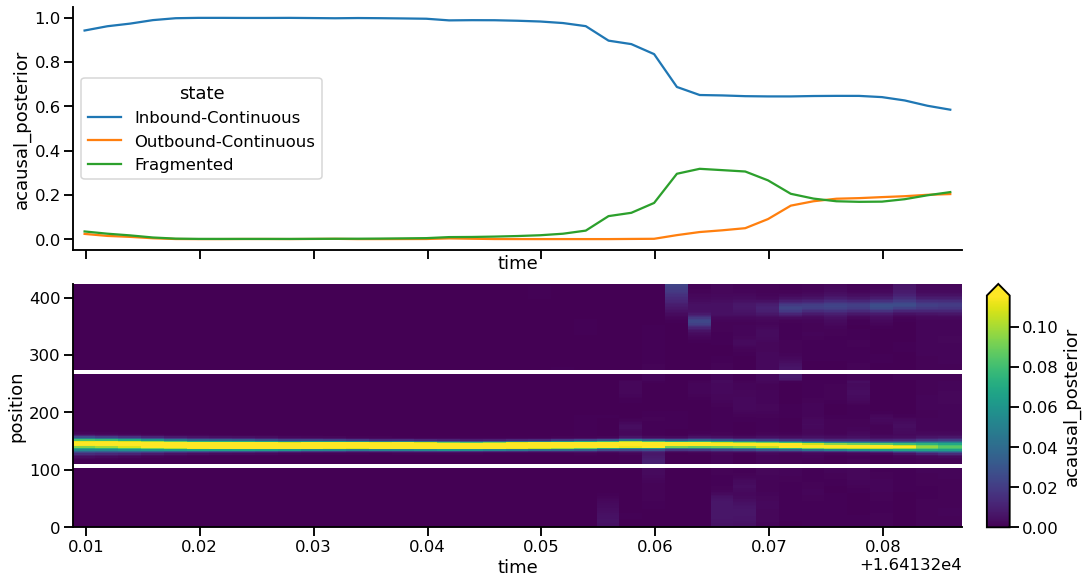

In [200]:
ripple_number = 9

plot_ripple_decode(data, classifier, ripple_number)

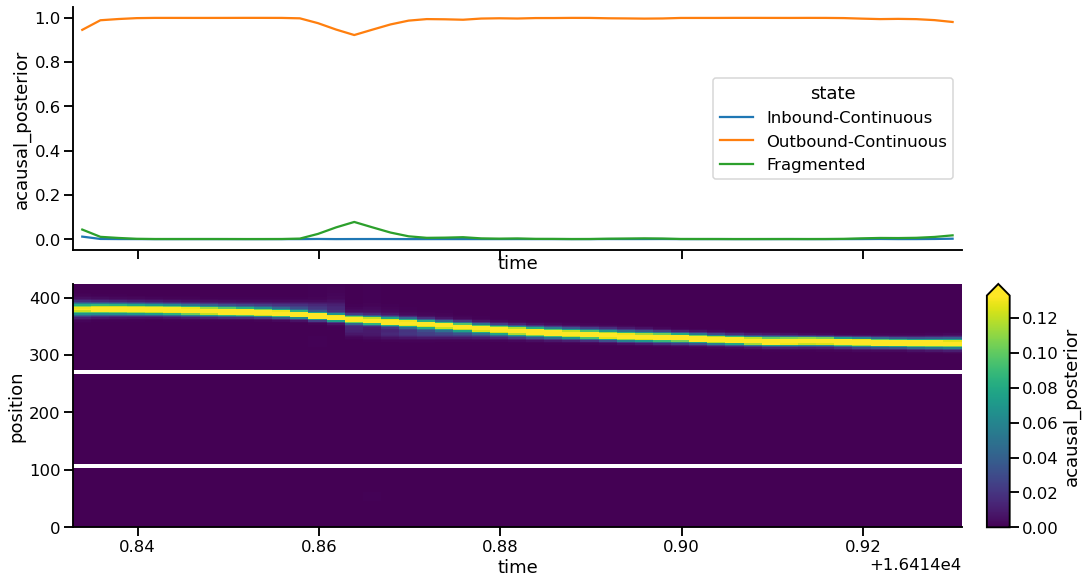

In [201]:
ripple_number = 10

plot_ripple_decode(data, classifier, ripple_number)

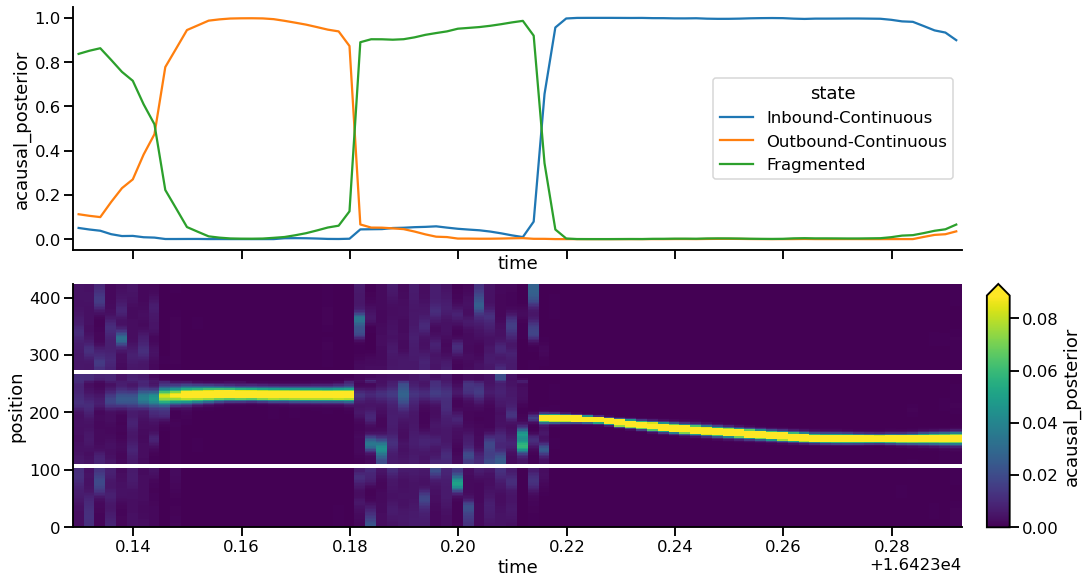

In [202]:
ripple_number = 11

plot_ripple_decode(data, classifier, ripple_number)

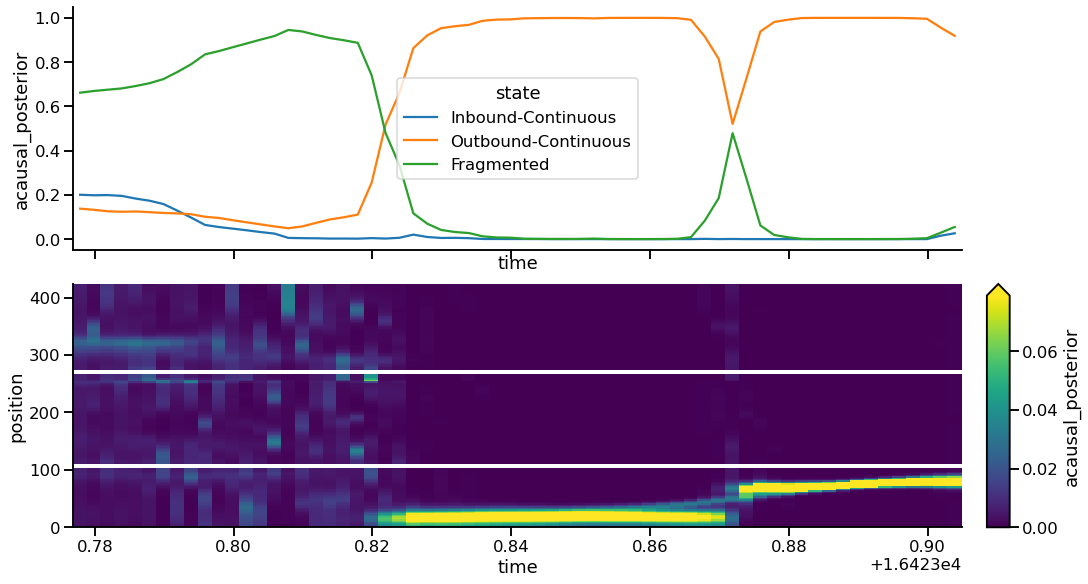

In [203]:
ripple_number = 12

plot_ripple_decode(data, classifier, ripple_number)

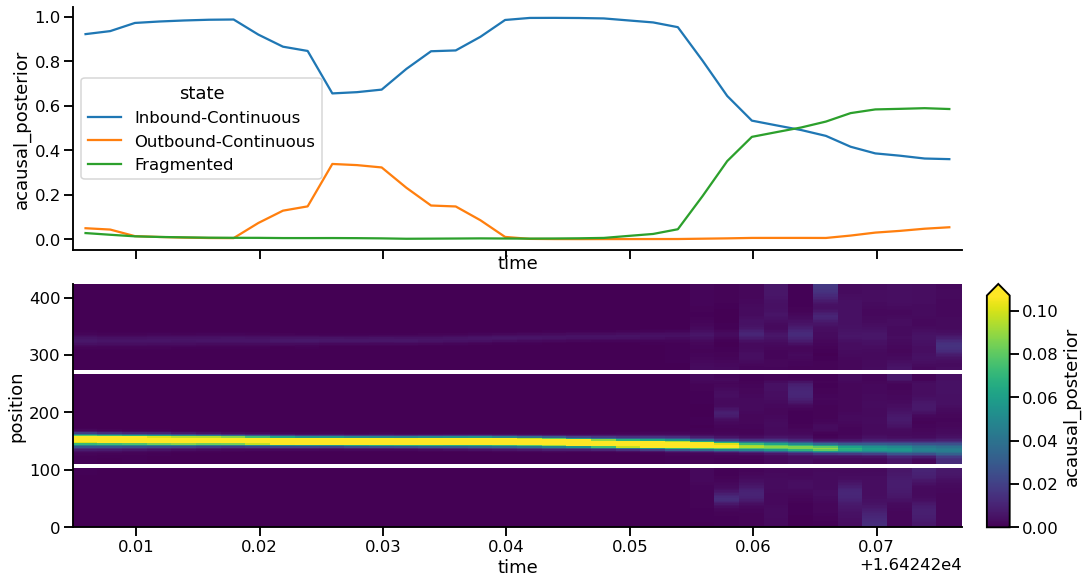

In [204]:
ripple_number = 15

plot_ripple_decode(data, classifier, ripple_number)

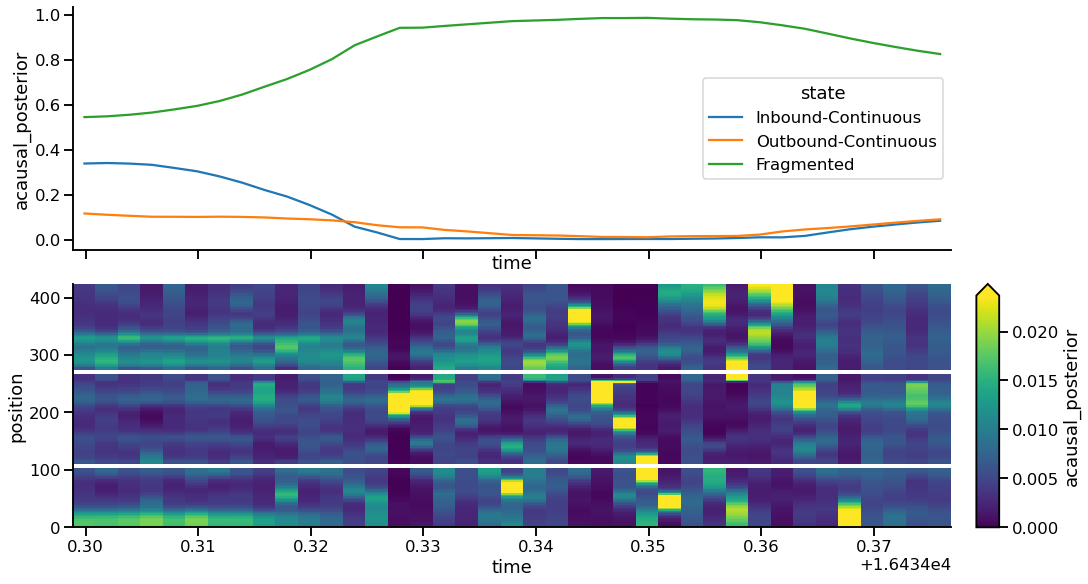

In [205]:
ripple_number = 16

plot_ripple_decode(data, classifier, ripple_number)

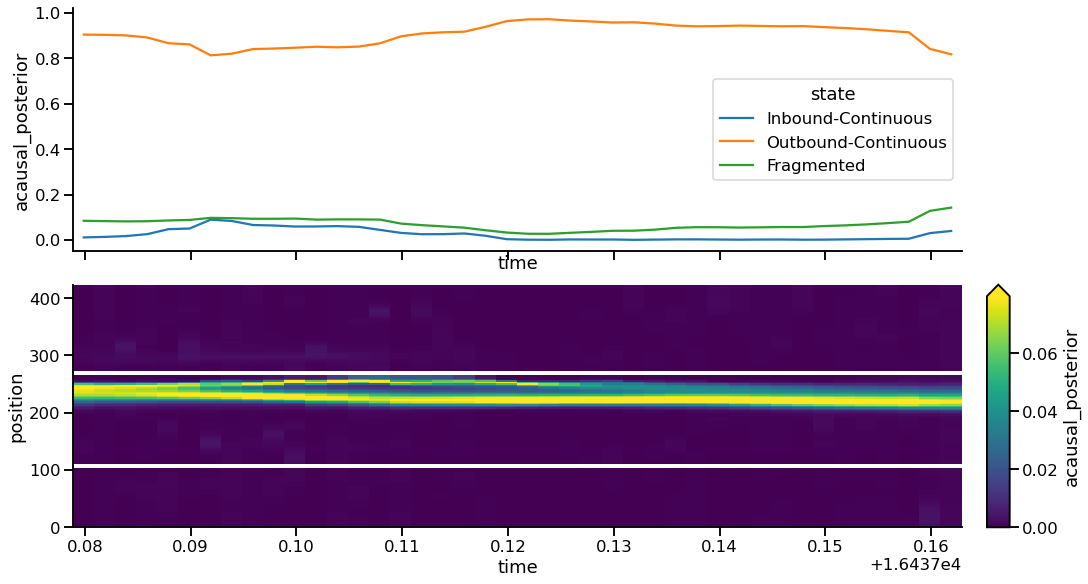

In [206]:
ripple_number = 17

plot_ripple_decode(data, classifier, ripple_number)

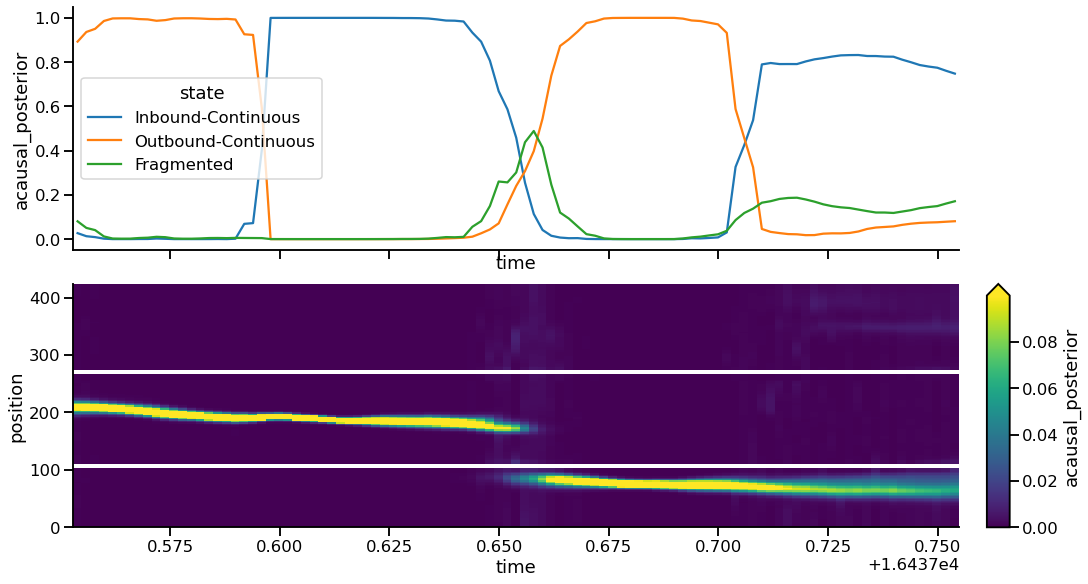

In [207]:
ripple_number = 18

plot_ripple_decode(data, classifier, ripple_number)

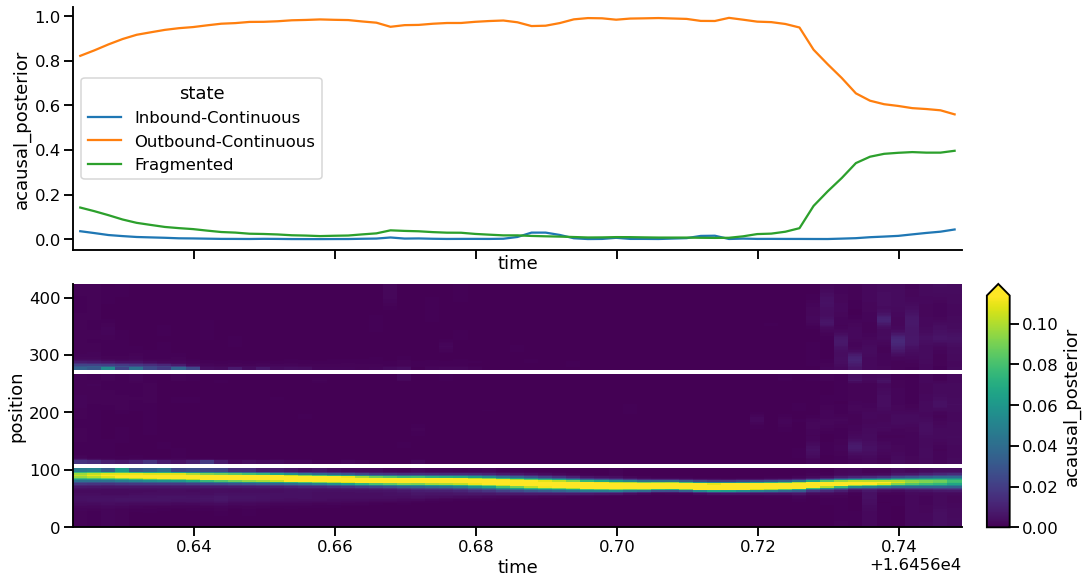

In [208]:
ripple_number = 19

plot_ripple_decode(data, classifier, ripple_number)

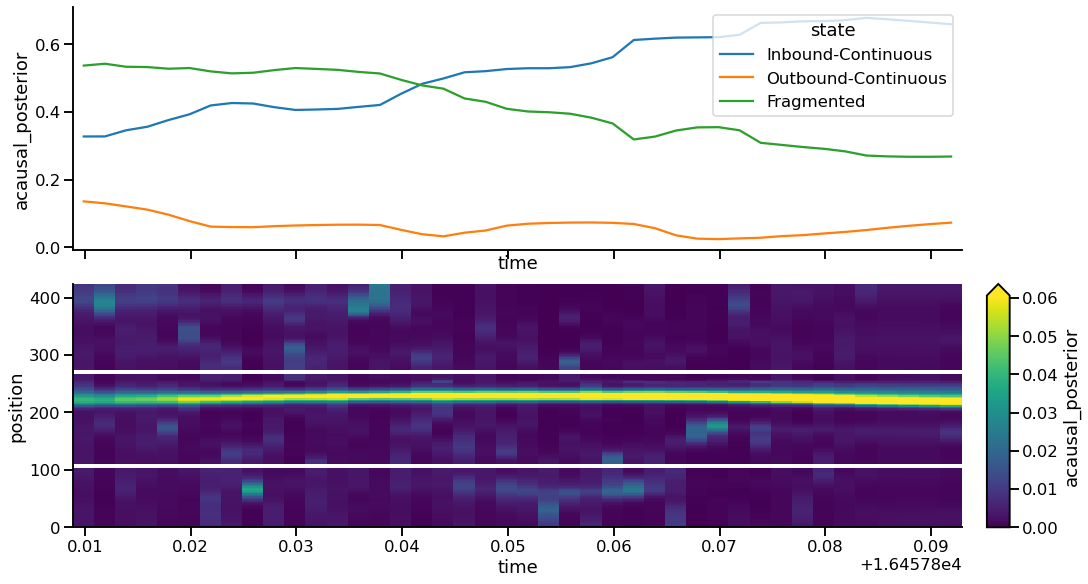

In [209]:
ripple_number = 20

plot_ripple_decode(data, classifier, ripple_number)

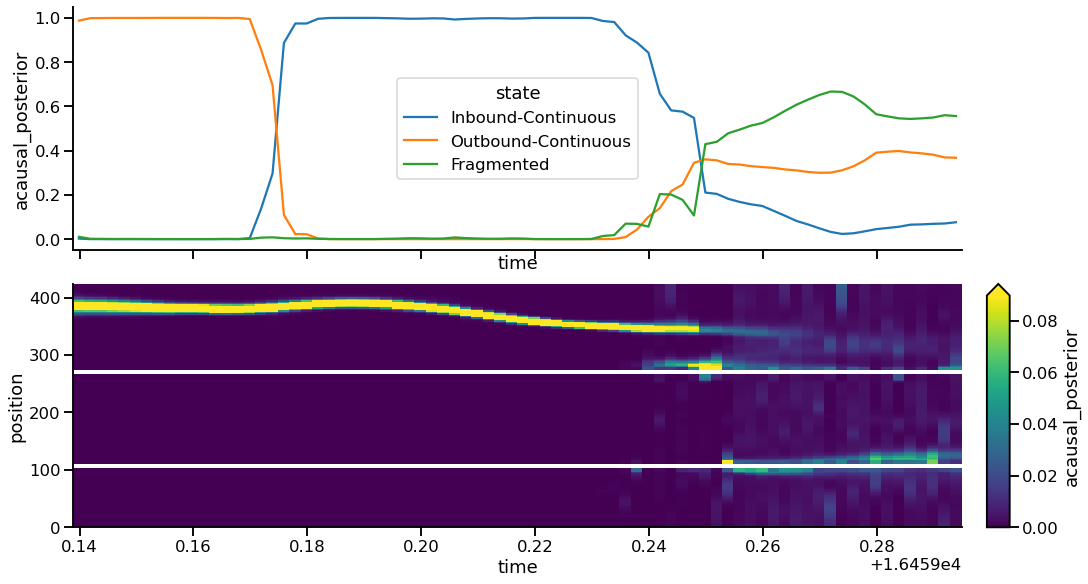

In [210]:
ripple_number = 21

plot_ripple_decode(data, classifier, ripple_number)

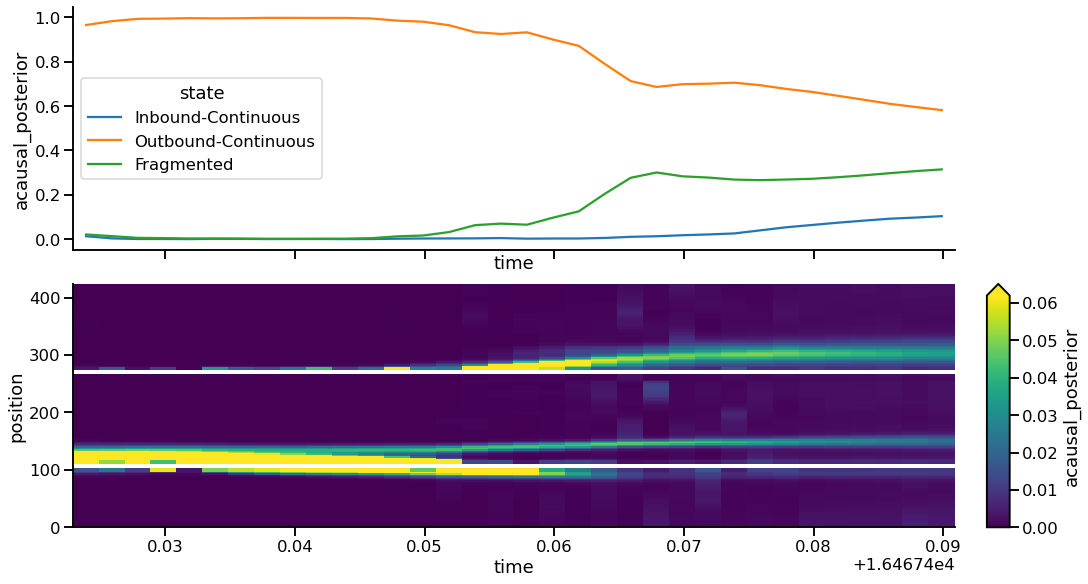

In [212]:
ripple_number = 22

plot_ripple_decode(data, classifier, ripple_number)

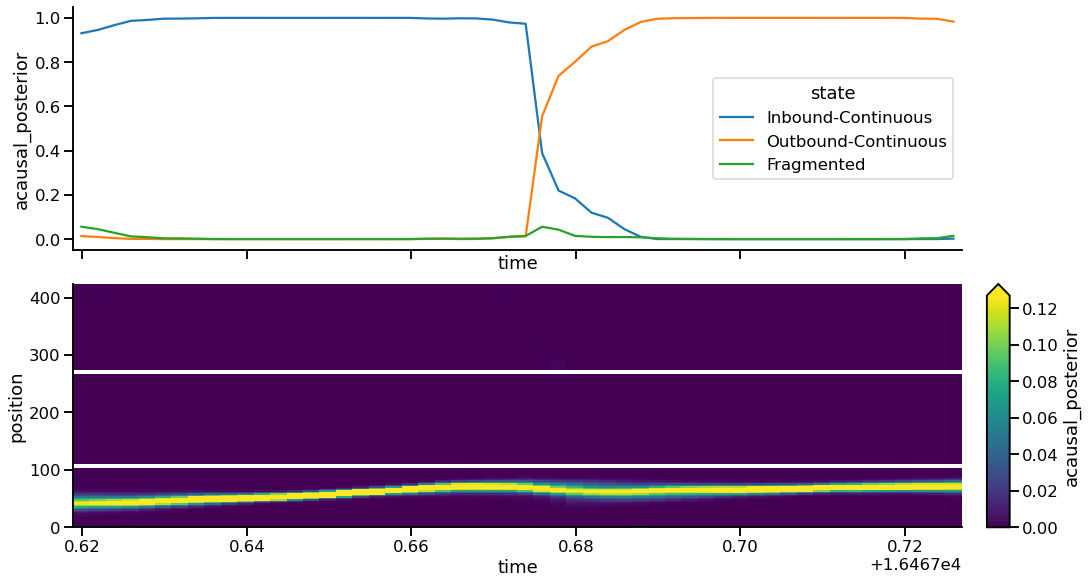

In [213]:
ripple_number = 23

plot_ripple_decode(data, classifier, ripple_number)

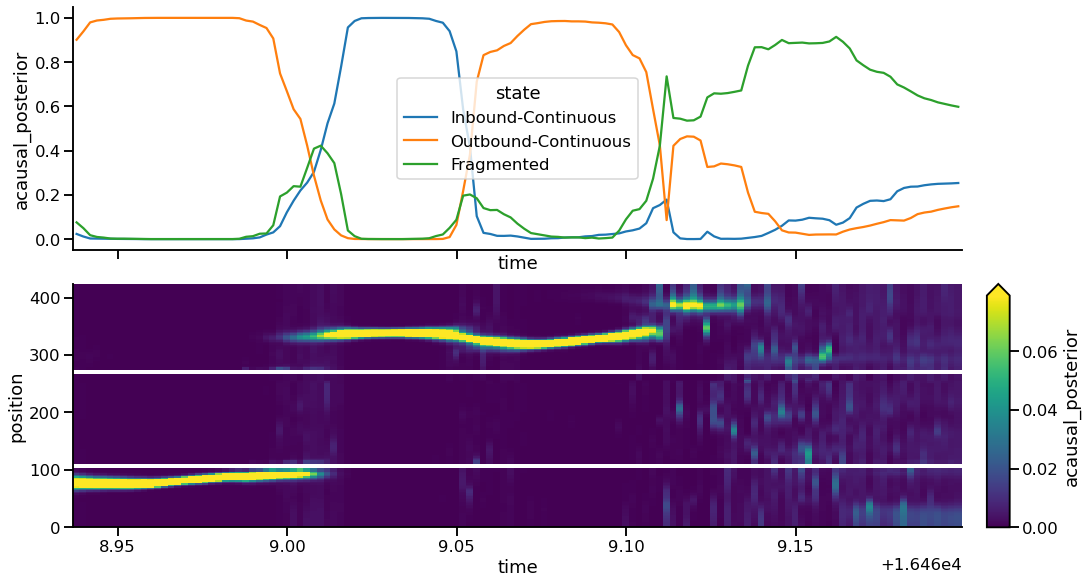

In [214]:
ripple_number = 24

plot_ripple_decode(data, classifier, ripple_number)

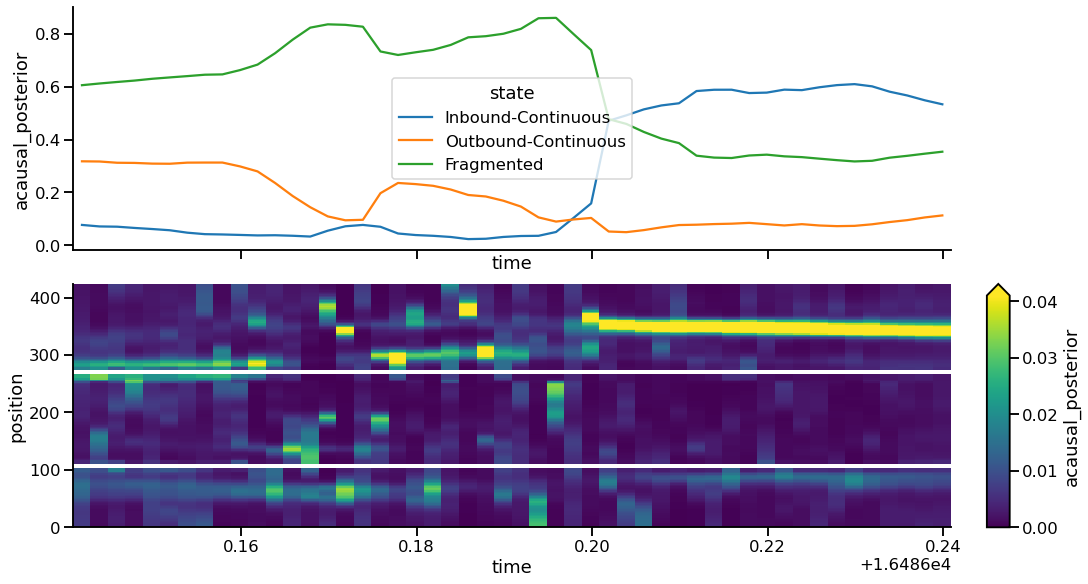

In [215]:
ripple_number = 25

plot_ripple_decode(data, classifier, ripple_number)